Let's prepare the data

In [48]:
import pandas as pd
births = pd.read_csv("births.csv")
print(births.head()) 
births['day'].fillna(0, inplace=True) 
births['day'] = births['day'].astype(int)

   year  month  day gender  births
0  1969      1  1.0      F    4046
1  1969      1  1.0      M    4440
2  1969      1  2.0      F    4454
3  1969      1  2.0      M    4548
4  1969      1  3.0      F    4548


C:\Users\Corentin\AppData\Local\Temp\ipykernel_16116\3940674149.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  births['day'].fillna(0, inplace=True)


In [49]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')
births.head()

,year,month,day,gender,births,decade
0,1969,1,1,F,4046,1960
1,1969,1,1,M,4440,1960
2,1969,1,2,F,4454,1960
3,1969,1,2,M,4548,1960
4,1969,1,3,F,4548,1960


Data exploration:

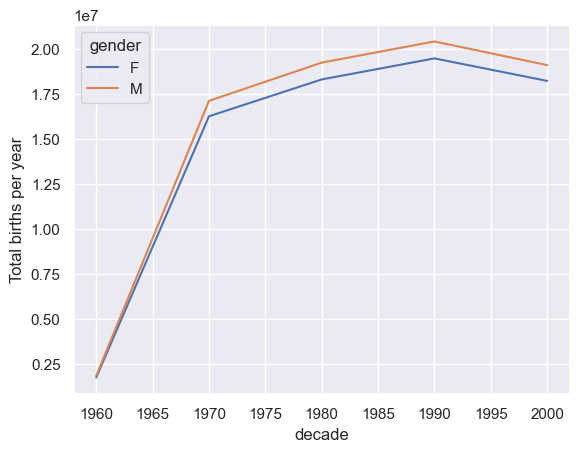

In [50]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set() 
birth_decade = births.pivot_table('births', index='decade', columns='gender', aggfunc='sum') 
birth_decade.plot() 
plt.ylabel("Total births per year") 
plt.show()

There are a few interesting features we can pull out of this dataset using the Pandas tools. We must start by cleaning the data a bit, removing outliers caused by mistyped dates or missing values. One easy way to remove these all at once is to cut outliers, we’ll do this via a robust sigma-clipping operation:

In [51]:
import numpy as np
quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

This final line is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution. With this we can use the query() method to filter out rows with births outside these values:

In [52]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
births['day'] = births['day'].astype(int)
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek

Using this we can plot births by weekday for several decades:

C:\Users\Corentin\AppData\Local\Temp\ipykernel_16116\3504355344.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])


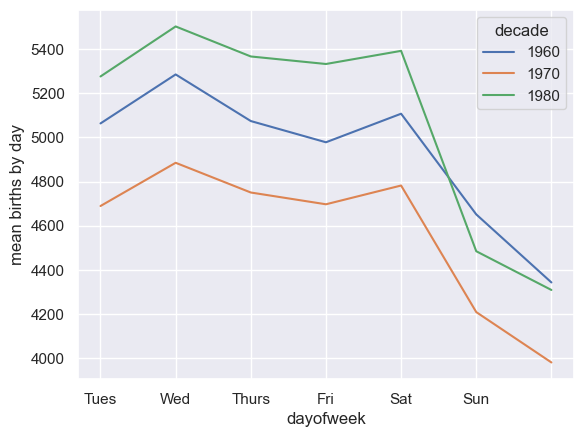

In [53]:
births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');
plt.show()

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

Another interesting view is to plot the mean number of births by the day of the year. Let’s first group the data by month and day separately:

       births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625
              births
2012-01-01  4009.225
2012-01-02  4247.400
2012-01-03  4500.900
2012-01-04  4571.350
2012-01-05  4603.625


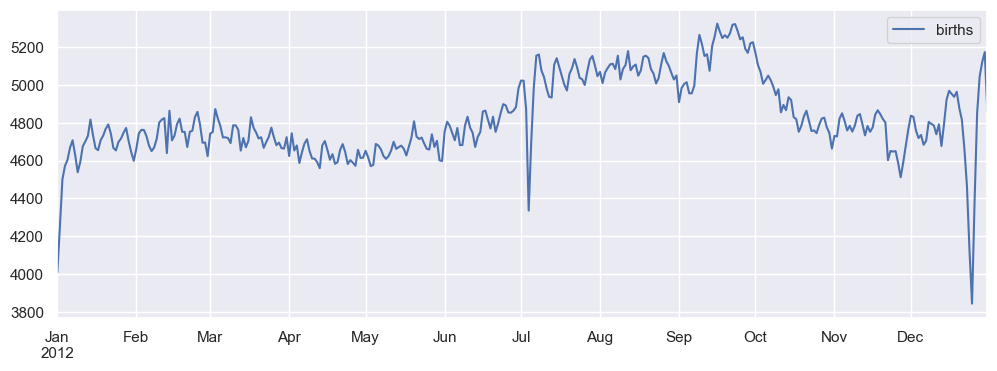

In [54]:
births_month = births.pivot_table('births', [births.index.month, births.index.day])
print(births_month.head())

births_month.index = [pd.Timestamp(2012, month, day)
                      for (month, day) in births_month.index]
print(births_month.head())

fig, ax = plt.subplots(figsize=(12, 4))
births_month.plot(ax=ax)
plt.show()

Evolution of the average number of births per day of the week over the years

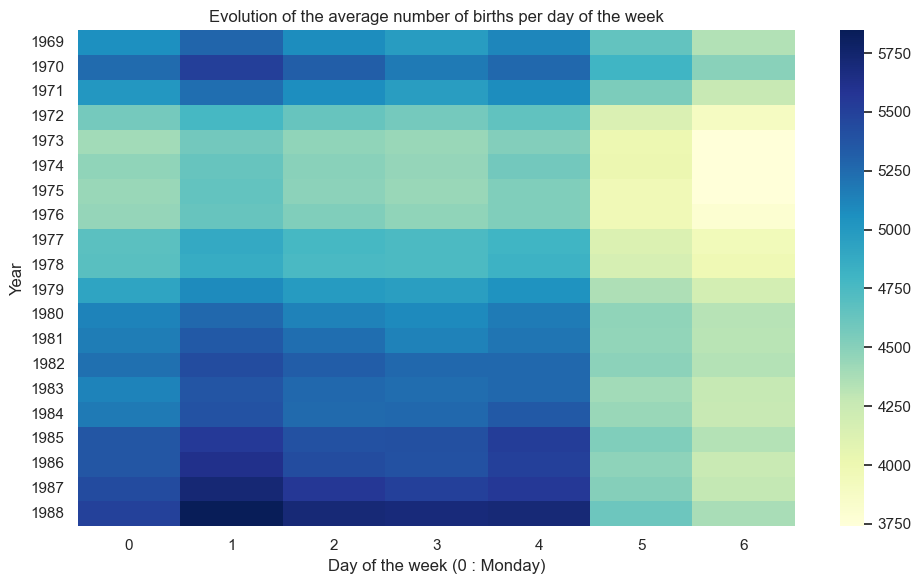

In [55]:
dow_year = births.groupby(['year', 'dayofweek'])['births'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(dow_year, cmap="YlGnBu", annot=False)
plt.title("Evolution of the average number of births per day of the week")
plt.xlabel("Day of the week (0 : Monday)")
plt.ylabel("Year")
plt.tight_layout()
plt.show()

We note that across the entire dataset, weekends have a lower number of births. Which confirms what we saw previously

We also see a general decline in the number of births between 1972 and 1978. As we can verify more generally:

<Axes: title={'center': 'Evolution of the average number of births per day'}, xlabel='year', ylabel='Average births'>

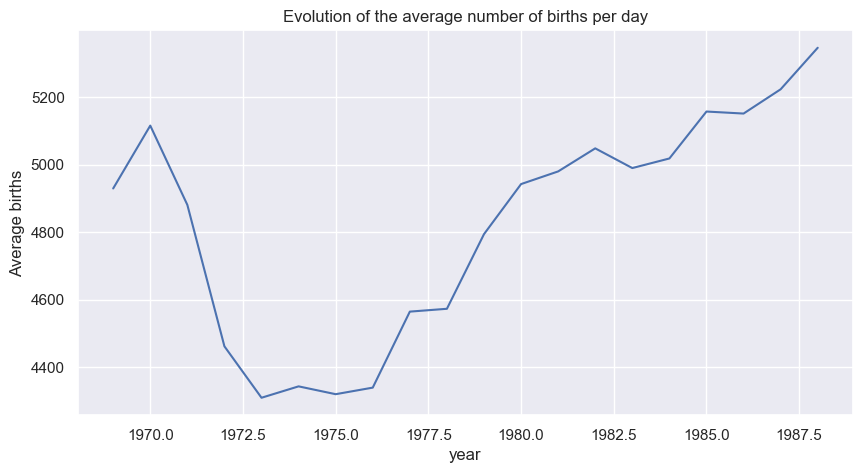

In [56]:
annual_avg = births.groupby('year')['births'].mean()
annual_avg.plot(figsize=(10,5), title="Evolution of the average number of births per day", ylabel="Average births")


We can expect a lack of correlation, but let's analyze whether gender and the days of the month and year are related to gender:

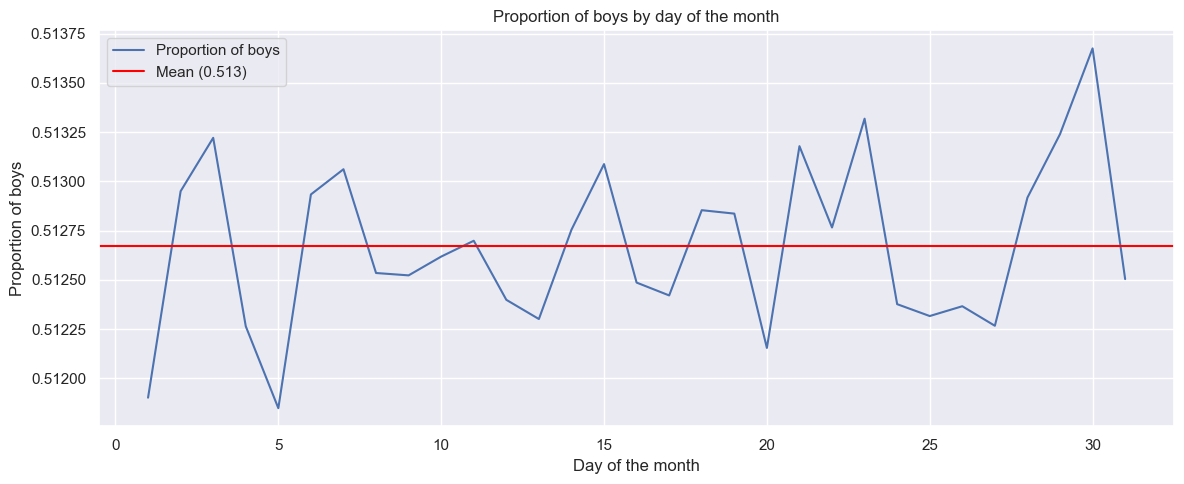

In [67]:
import matplotlib.pyplot as plt

gender_day = births[births['gender'] == 'M'].groupby('day')['births'].sum() / births.groupby('day')['births'].sum()
mean_gender = births[births['gender'] == 'M']['births'].sum() / births['births'].sum()

plt.figure(figsize=(12,5))
gender_day.plot(label="Proportion of boys")
plt.axhline(mean_gender, color='red', label=f"Mean ({mean_gender:.3f})")
plt.title("Proportion of boys by day of the month")
plt.xlabel("Day of the month")
plt.ylabel("Proportion of boys")
plt.legend()
plt.tight_layout()
plt.show()


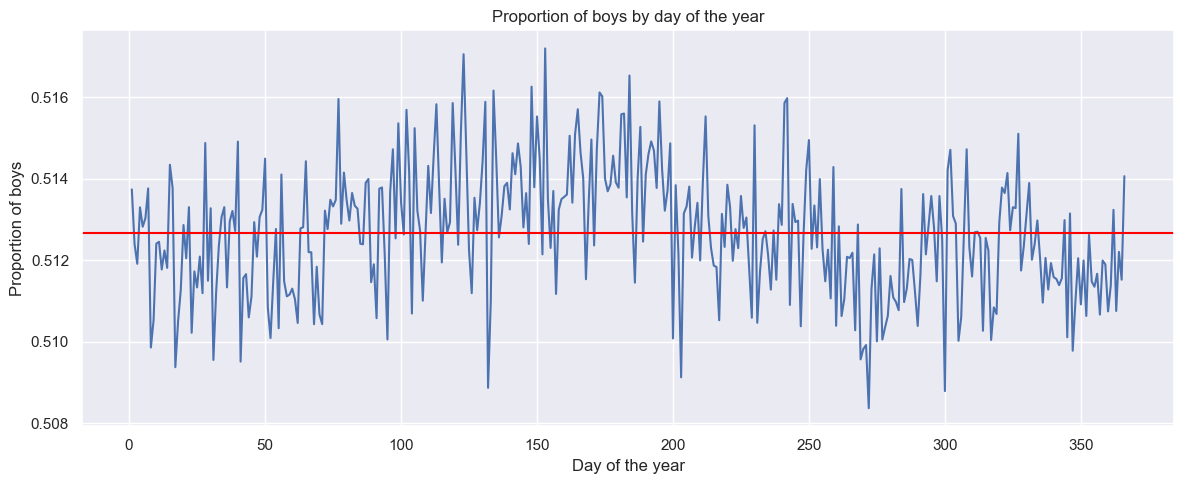

In [63]:
births['day_of_year'] = births.index.dayofyear

gender_doy = births[births['gender'] == 'M'].groupby('day_of_year')['births'].sum() / births.groupby('day_of_year')['births'].sum()
mean_gender = births[births['gender'] == 'M']['births'].sum() / births['births'].sum()

gender_doy.plot(figsize=(12,5))
plt.axhline(mean_gender, color='red', label=f"Mean ({mean_gender:.3f})")
plt.title("Proportion of boys by day of the year")
plt.xlabel("Day of the year")
plt.ylabel("Proportion of boys")
plt.tight_layout()
plt.show()


In [ ]:
import scipy.stats as stats

contingency = pd.crosstab(births['dayofweek'], births['gender'])

chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi² = {chi2:.2f}, p-value = {p:.4f}")


Chi² = 0.00, p-value = 1.0000


As expected, there is really no correlation.